# Objectives

1. Estimate Clock Model
1. Filter Outliers
1. Add Clock Model to Dataframe

NOTE: Filter outliers after clock model estimated?

---
# Setup

## Modules

In [1]:
# Bio
import treetime
from Bio import Phylo

# Plotting
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
sns.set_style('whitegrid')

# Stats
import pandas as pd

# System IO
import dill
import copy
import os
import io
import sys

## Paths

In [2]:
# snakemake output
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"

# jupyter notebook output
tree_df_path = "../../results/parse_tree/parse_tree.tsv"
tree_df_dill = "../../results/parse_tree/parse_tree.df.obj"
tree_path = "../../results/parse_tree/parse_tree.nwk"
auspice_latlon_path = "../../results/parse_tree/parse_tree_latlon.tsv"
auspice_colors_path = "../../results/parse_tree/parse_tree_colors.tsv"

# static dir
auspice_config_path = "../../config/auspice_config.json"
auspice_remote_dir_path = "../../auspice/"


outdir = "../../results/clock_model"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "clock_model"

# Clock model params

N_IQD = 3
MAX_ITER = 3
TC = "skyline"

## Import Tree

In [4]:
tree = Phylo.read(tree_path, "newick")
tree.ladderize(reverse=False)

## Import Dataframe

In [5]:
with open(tree_df_dill, "rb") as infile:
    tree_df = dill.load(infile)
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number
Name,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0.000000e+00,black,0.000000,17.820516,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA3541827,NA,NA,3.850400e-06,grey,0.000004,1.000000,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0
NODE1,100,85,1.327080e-05,black,0.000013,3.156250,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
SAMEA104233046,NA,NA,2.248400e-06,grey,0.000016,2.000000,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0
NODE2,100,94.6,1.363640e-05,black,0.000027,4.312500,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE630,19,48.8,6.380000e-08,black,0.000076,632.750000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
GCA_000269245.1_ASM26924v1_genomic,NA,NA,2.230000e-07,grey,0.000076,632.000000,PY-113,2010,-11,Peru,La Libertad,-6.86997,-75.0459,-8,-78.5,Orientalis,1.ORI,1.ORI1,SAMN02141506,KEEP: Assembly Modern,1
NODE631,37,49.6,2.936000e-07,black,0.000076,633.500000,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


# 1. Filter Outlier Tips

## Parse Tip Dates

In [6]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tree_df_path, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v
        
# Add Reference
dates["Reference"] = REF_DATE


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.


---
# 1. Estimate Clock Model

In [7]:
# Initialize stdout capture
# print("Estimating clock model...")
# old_stdout = sys.stdout
# new_stdout = io.StringIO()
# sys.stdout = new_stdout

# branch_length_mode:input --> tMRCA ~20,000 YBP

tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,                     
                       tree=tree, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,
                      )

tt.run(
    # Stable Parameters
    max_iter=1,    
    n_iqd=N_IQD,   
    verbose=4,    
    infer_gtr=True,  
    use_covariation=False,     
    root=tt.tree.root,       
    resolve_polytomies=True,     
    vary_rate=True,    
    # Variable Parameters
    relaxed_clock={"slack" : 0.1, "coupling": 0},    
    branch_length_mode = "marginal", # joint or marginal  
    Tc=TC,    
    time_marginal="assign",
    )

tt.tree.ladderize(reverse=False)

# Save stdout to file
# output = new_stdout.getvalue()
# out_path = os.path.join(outdir, SCRIPT_NAME + "_estimate.log") 
# with open(out_path, "w") as file:
#     file.write(output)
# # Restore stdout
# sys.stdout = old_stdout
# print("Standard output restored, logging to file disabled.")


0.00	-TreeAnc: set-up

1.30	-SequenceData: loaded alignment.
1.30	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.30	-SeqData: making compressed alignment...

4.19	-SequenceData: constructed compressed alignment...
4.52	--ClockTree: Setting precision to level 2

4.62	-ClockTree._assign_dates: assigned date contraints to 634 out of 634 tips.

4.62	-TreeAnc.infer_ancestral_sequences with method: probabilistic, marginal

4.62	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
4.62	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
4.62	---Attaching sequence profiles to leafs...
7.18	---Post

60.05	---Computing root node sequence and total tree likelihood...
60.05	---Preorder: computing marginal profiles...
61.68	---TreeAnc._ml_anc_marginal: ...done
61.77	--TreeAnc.optimize_tree_marginal: iteration 0, LH=-6602064.25 (-819.01),
     	  delta branch_length=-0.0000, total branch_length 0.0014

61.77	-TreeAnc.optimize_tree_marginal: deltaLH=-819.006407, stopping iteration.

61.77	###TreeTime.run: INITIAL ROUND

61.77	-ClockTree: Maximum likelihood tree optimization with temporal constraints
61.77	--ClockTree.init_date_constraints...
61.77	---ClockTree.init_date_constraints: Initializing branch length
     	   interpolation objects...
279.10	--ClockTree.date2dist: Setting new molecular clock. rate=8.742e-09,
      	  R^2=0.2837
279.10	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
      	    excluding it from the optimization process. Date constraint will be
      	    ignored!
279.10	----ClockTree.init_date_constraints -- WARNING: Branch is marked as b

328.80	--ClockTree.date2dist: Setting new molecular clock. rate=1.055e-08,
      	  R^2=0.2837
328.80	--TreeTime.reroot: Tree was re-rooted to node NODE0
329.31	--ClockTree.date2dist: Setting new molecular clock. rate=1.055e-08,
      	  R^2=0.2837

329.31	###TreeTime.run: rerunning timetree after rerooting

329.31	-ClockTree: Maximum likelihood tree optimization with temporal
      	 constraints
329.31	--ClockTree.init_date_constraints...

329.31	-TreeAnc.infer_ancestral_sequences with method: probabilistic, marginal
329.31	--TreeAnc._ml_anc_marginal: type of reconstruction: Marginal
329.31	---Attaching sequence profiles to leafs...
329.33	---Postorder: computing likelihoods...
330.31	---Computing root node sequence and total tree likelihood...
330.31	---Preorder: computing marginal profiles...
332.01	---TreeAnc._ml_anc_marginal: ...done
332.10	---ClockTree.init_date_constraints: Initializing branch length
      	   interpolation objects...
542.75	--ClockTree.date2dist: Setting new mo

587.79	--Coalescent:optimize_skyline:... current LH: 7932.052960
741.23	--Coalescent:optimize_skyline:...done. new LH: 8460.294489
741.23	--optimized a skyline
relaxed_clock {'slack': 0.1, 'coupling': 0}
742.29	--TreeTime.relaxed_clock: slack=0.100000, coupling=0.000000

742.33	-TreeTime.resolve_polytomies: resolving multiple mergers...
742.65	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
742.65	---TreeTime._poly.merge_nodes: Delta-LH = 0.36
742.90	---TreeTime._poly.merge_nodes: creating new node as child of NODE107
742.90	---TreeTime._poly.merge_nodes: Delta-LH = 0.144
743.22	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
743.22	---TreeTime._poly.merge_nodes: Delta-LH = 0.051
743.45	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
743.45	---TreeTime._poly.merge_nodes: Delta-LH = 0.051
743.67	---TreeTime._poly.merge_nodes: creating new node as child of NODE117
743.67	---TreeTime._poly.merge_nodes: Delta-LH = 0.051
743.91	

1050.67	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
1051.21	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1051.21	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1051.21	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1051.21	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1051.21	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1051.21	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1051.21	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1051.21	----ClockTree.convert_dates -- WARNING: node which is ma

1344.91	--ClockTree - Joint reconstruction:  Propagating root -> leaves...
1345.43	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1345.43	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1345.43	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1345.43	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1345.43	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1345.43	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1345.43	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1345.43	----ClockTree.convert_dates -- WARNING: node which is ma

1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----ClockTree.convert_dates -- WARNING: node which is marked as "BAD"
       	    optimized later than present day
1628.73	----Cloc

2121.90	--ClockTree.date2dist: Setting new molecular clock. rate=1.007e-08,
       	  R^2=0.2837
2121.90	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
2121.90	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
2121.90	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
2121.90	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ignored!
2121.90	----ClockTree.init_date_constraints -- WARNING: Branch is marked as bad,
       	    excluding it from the optimization process. Date constraint will be
       	    ig

## Quick Checks

In [22]:
# Common Ancestor
tt.tree.common_ancestor("NODE0")

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



Clade(_v=0, bad_branch=False, branch=2.148814885614286e-07, branch_length=0.1, clock_length=2.148814885614286e-07, date='-3942-01-25', dist2root=0.0, mutation_length=2.148814885614286e-07, name='NODE0', original_length=0.0)

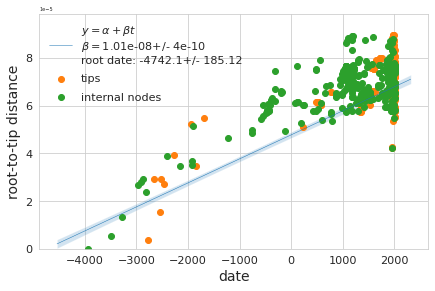

In [23]:
# RTT Regression
tt.plot_root_to_tip(add_internal=True, label=True)

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_rtt-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



2852.65	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


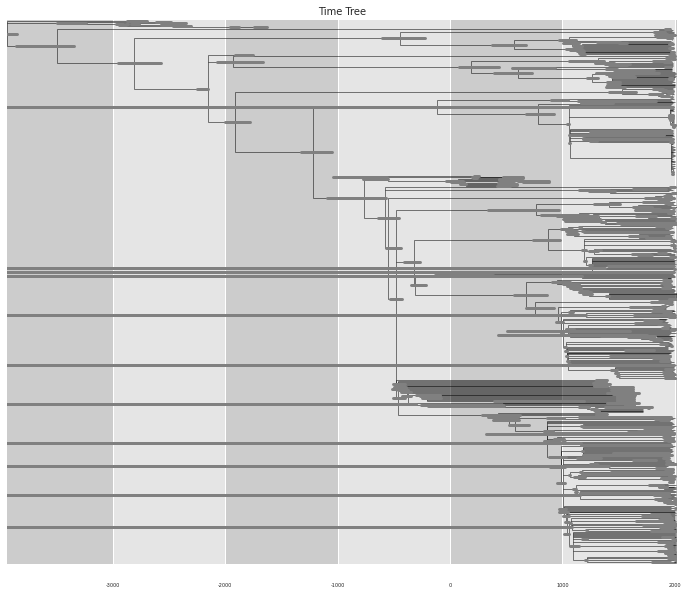

In [27]:
# Timetree
tt_copy = copy.deepcopy(tt)
if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    fig, ax1 = treetime.treetime.plot_vs_years(tt_copy,
                             confidence=(0.05,0.95), 
                             label_func = lambda x:"",
                             do_show=False)
else:
    fig, ax1 = treetime.treetime.plot_vs_years(tt_copy,
                             label_func = lambda x:"",
                             do_show=False)    
ax1.set_title("Time Tree")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_timetree-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

# 2. Filter Outliers

## Prune 'Bad' Branches from Tree

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



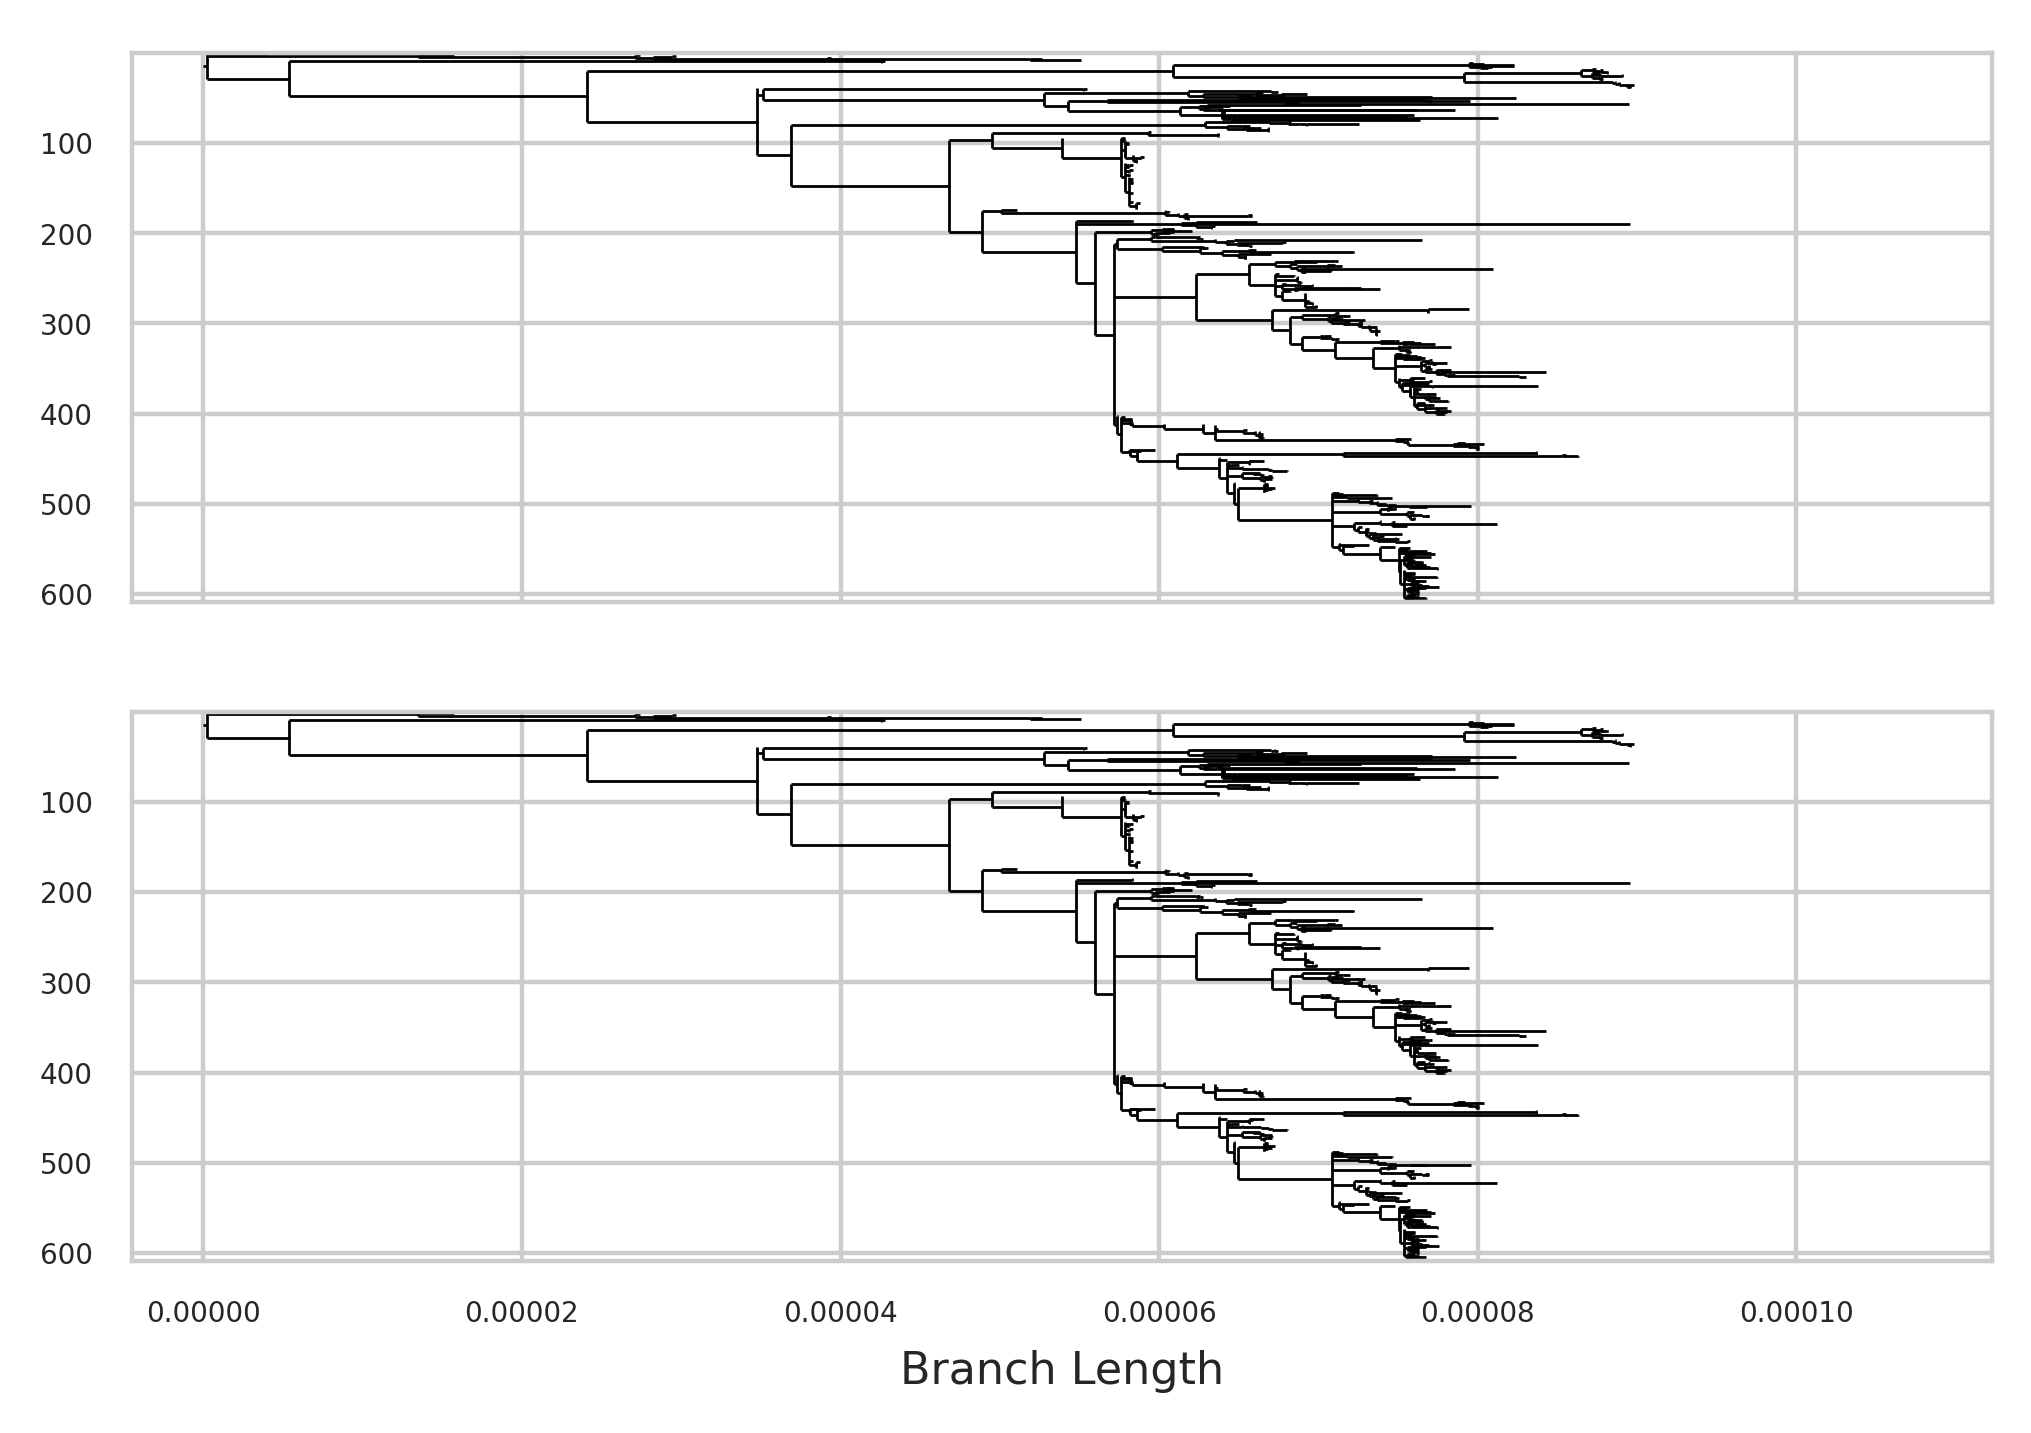

In [28]:
tt_pre = copy.deepcopy(tt)
tt_prune = copy.deepcopy(tt)

# Color branches and set to divtree
for n in tt_pre.tree.find_clades():
    n.branch_length=n.mutation_length
    if n.bad_branch:
        n.color = "red"
for n in tt_prune.tree.find_clades():
    n.branch_length=n.mutation_length

bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

while len(bad_nodes) > 0:
    for node in bad_nodes:
        if node.is_terminal():
            print("PRUNING:", node.name)
            tt_prune.tree.prune(node)
    bad_nodes = [c for c in tt_prune.tree.find_clades() if c.bad_branch]

fig, (ax1,ax2) = plt.subplots(2, sharex=True, dpi=dpi)

Phylo.draw(tt_pre.tree, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax1,
        )  
Phylo.draw(tt_prune.tree, 
        show_confidence=False, 
        label_func = lambda x: '',
        do_show=False,
        axes=ax2,
        )

ax1.set_xlabel("")
ax1.set_ylabel("")
ax2.set_xlabel("Branch Length")
ax2.set_ylabel("")

# Save
out_path = os.path.join(outdir, SCRIPT_NAME + "_divtree-pre." + FMT) 
plt.savefig(out_path, 
            dpi=dpi, 
            bbox_inches = "tight")

## Update tt variable

In [29]:
tt = tt_prune

## Timetree After Pruning

2936.97	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


Text(0.5, 1.0, 'Time Tree')

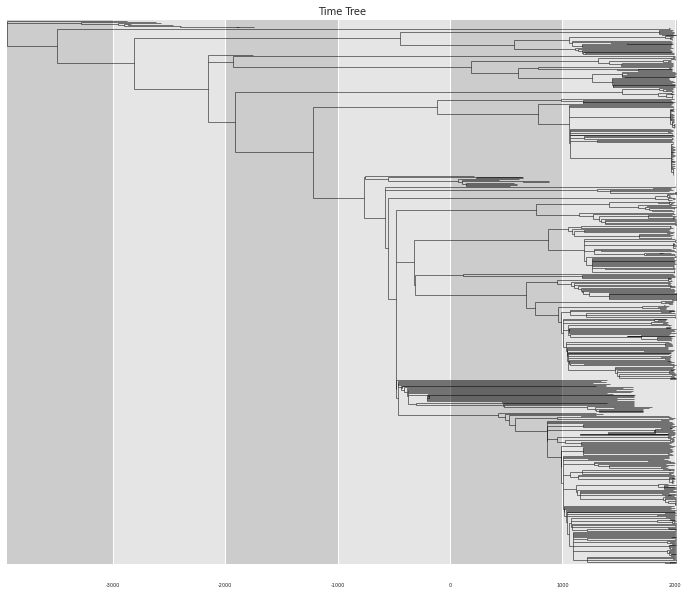

In [30]:
# Timetree
fig, ax1 = treetime.treetime.plot_vs_years(tt,
                         #confidence=(0.05,0.95), 
                         label_func = lambda x:"",
                         do_show=False)
ax1.set_title("Time Tree")

## Remove Collapsed Nodes from Dataframe

In [31]:
tt_nodes = [c.name for c in tt.tree.find_clades()]
for rec in tree_df.iterrows():
    node = rec[0]
    if node not in tt_nodes:
        tree_df.drop(node, inplace=True)
        
tree_df

,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0,black,0,17.8205,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,2.148815e-07,-3942-01-25,-3941.933155,"[-4315.057346152413, -3825.691314102577]",0.100000,0.100000,14.972173,-3941.933155,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.8504e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,3.209214e-09,0.318724,3.850400e-06,-2876-01-01,-2876.000000,"[-2875.9999999999995, -2694.522797789115]",1065.933155,1066.033155,1.000000,-2776.500000,0.000004,False
NODE1,100,85,1.32708e-05,black,1.32708e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.833871e-08,1.821313,1.327080e-05,-3282-04-16,-3281.711767,"[-3522.6818465012643, -3230.4491929451024]",660.221387,660.321387,3.156250,-3281.711767,0.000013,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.55192e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,3.018238e-09,0.299757,2.248400e-06,-2621-01-01,-2621.000000,"[-2620.9999999999995, -2481.9439805600136]",660.711767,1321.033155,2.000000,-2546.500000,0.000016,False
NODE2,100,94.6,1.36364e-05,black,2.69072e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.086223e-08,3.065089,1.363640e-05,-2960-01-30,-2959.920114,"[-2979.235011053643, -2907.2256450899786]",321.791653,982.113041,4.312500,-2959.920114,0.000027,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000302,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,0.000000e+00,1961-01-02,1961.004341,"[1180.7283363217405, 1976.0]",779.525967,5903.037495,455.500000,1961.004341,0.000065,False
NODE_0000317,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,0.000000e+00,1963-06-01,1963.415829,"[1168.641040976287, 1964.0]",793.937473,5905.448984,475.500000,1963.415829,0.000066,False
NODE_0000322,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,0.000000e+00,1942-05-13,1942.363408,"[1181.9071178725965, 1977.0]",759.885048,5884.396563,486.500000,1942.363408,0.000066,False


---
# 3. Add Clock Model to Dataframe

- Rates
- Dates
- RTT Regression
- Skyline

## Rates

In [32]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Dates

In [42]:
# Create new columns
tree_df["timetree_raw_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_num_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

if hasattr(tt.tree.root, "marginal_inverse_cdf"):
    tree_df["timetree_num_date_confidence"] = [[NO_DATA_CHAR,NO_DATA_CHAR] for row in range(0,len(tree_df))]
    
HAS_MARGINAL = False
# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

CONF_LOWER_BOUND = -100000
for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):   
        # Set the boolean flag on the first time encountered
        if not HAS_MARGINAL:
            HAS_MARGINAL = True
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE)
        if conf[0] < CONF_LOWER_BOUND:
            print("Bad lower date estimated for:", c.name,"\t", conf[0], ". Setting to", conf[1])          
            conf[0] = conf[1]
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_num_date_confidence"][0] = conf[0]
        tree_df.at[c.name, "timetree_num_date_confidence"][1] = conf[1]
        
    tree_df.at[c.name, "timetree_raw_date"] = c.date  
    tree_df.at[c.name, "timetree_num_date"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

5416.67	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years
Bad lower date estimated for: NODE298 	 -4098732.120204412 . Setting to 1380.6317100308547
Bad lower date estimated for: NODE305 	 -5251247.369957697 . Setting to 1176.4781728733917
Bad lower date estimated for: NODE353 	 -1401217.0076374665 . Setting to 1210.4782723475005
Bad lower date estimated for: NODE410 	 -3000505.9522247873 . Setting to 1195.4780069429953
Bad lower date estimated for: NODE448 	 -5394463.547208355 . Setting to -307.00250976090865
Bad lower date estimated for: NODE497 	 -2748315.8458281104 . Setting to 1169.4783557325463
Bad lower date estimated for: NODE524 	 -2966223.254487233 . Setting to 1414.358109814858
Bad lower date estimated for: NODE537 	 -1440051.2683143727 . Setting to 1159.478412732546
Bad lower date estimated for: NODE589 	 -383595.0153945329 . Setting to 1086.8314588963726


## RTT

In [43]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

5420.22	--ClockTree.branch_length_to_years: setting node positions in units of
       	  years


,UFboot,sCF,Branch_Length,Branch_Support_Color,coord_x,coord_y,Strain,Date,DateBP,Country,Province,CountryLat,CountryLon,ProvinceLat,ProvinceLon,Biovar,Branch_Major,Branch_Minor,BioSample,BioSampleComment,Branch_Number,timetree_rate,timetree_rate_fold_change,timetree_mutation_length,timetree_raw_date,timetree_num_date,timetree_num_date_confidence,timetree_clock_length,timetree_coord_x,timetree_coord_y,timetree_reg_x,timetree_reg_y,timetree_reg_bad
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NODE0,NA,NA,0,black,0,17.8205,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,2.148815e-07,-3942-01-25,-3941.933155,"[-4315.057346152413, -3825.691314102577]",0.100000,0.100000,14.972173,-3941.933155,0.000000,False
SAMEA3541827,NA,NA,3.8504e-06,grey,3.8504e-06,1,RISE509,[-2876:-2677],[-4897:-4698],Russia,Krasnoyarsk Krai,64.6863,97.7453,63.3234,97.098,Bronze Age,0.PRE,0.PRE2,SAMEA3541827,KEEP: SRA Ancient,0,3.209214e-09,0.318724,3.850400e-06,-2876-01-01,-2876.000000,"[-2875.9999999999995, -2694.522797789115]",1065.933155,1066.033155,1.000000,-2776.500000,0.000004,False
NODE1,100,85,1.32708e-05,black,1.32708e-05,3.15625,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.833871e-08,1.821313,1.327080e-05,-3282-04-16,-3281.711767,"[-3522.6818465012643, -3230.4491929451024]",660.221387,660.321387,3.156250,-3281.711767,0.000013,False
SAMEA104233046,NA,NA,2.2484e-06,grey,1.55192e-05,2,Gyvakarai1,[-2621:-2472],[-4642:-4493],Lithuania,Panevezys County,55.35,23.75,55.9156,25.0312,Bronze Age,0.PRE,0.PRE1,SAMEA104233046,KEEP: SRA Ancient,0,3.018238e-09,0.299757,2.248400e-06,-2621-01-01,-2621.000000,"[-2620.9999999999995, -2481.9439805600136]",660.711767,1321.033155,2.000000,-2546.500000,0.000016,False
NODE2,100,94.6,1.36364e-05,black,2.69072e-05,4.3125,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,3.086223e-08,3.065089,1.363640e-05,-2960-01-30,-2959.920114,"[-2979.235011053643, -2907.2256450899786]",321.791653,982.113041,4.312500,-2959.920114,0.000027,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NODE_0000302,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,0.000000e+00,1961-01-02,1961.004341,"[1180.7283363217405, 1976.0]",779.525967,5903.037495,455.500000,1961.004341,0.000065,False
NODE_0000317,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,0.000000e+00,1963-06-01,1963.415829,"[1168.641040976287, 1964.0]",793.937473,5905.448984,475.500000,1963.415829,0.000066,False
NODE_0000322,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,1.006895e-08,1.000000,0.000000e+00,1942-05-13,1942.363408,"[1181.9071178725965, 1977.0]",759.885048,5884.396563,486.500000,1942.363408,0.000066,False


## Skyline

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



	Skyline assuming 50 gen/year and approximate confidence bounds (+/- 2.000000 standard deviations of the LH)
	date 	N_e 	lower 	upper
	-4022.9	51923.2	20198.1	133479.1
	-3704.9	65637.2	33690.2	127878.2
	-3386.9	83307.6	42979.3	161476.9
	-3068.9	89142.8	44906.6	176955.0
	-2750.9	101584.4	53836.5	191680.0
	-2432.9	114906.7	57978.8	227730.8
	-2114.9	126011.0	64904.1	244649.7
	-1796.9	178399.8	92129.3	345454.5
	-1478.9	249031.2	123509.1	502121.0
	-1160.9	265333.4	130827.6	538126.7
	-842.9	271942.1	140722.9	525518.6
	-524.9	298066.8	154675.7	574387.6
	-207.0	316847.1	158504.1	633372.3
	111.0	300363.3	167590.1	538326.0
	429.0	342359.0	200092.4	585777.9
	747.0	400069.6	236394.4	677070.7
	1065.0	367713.1	242235.0	558189.3
	1383.0	860807.9	657801.7	1126464.5
	1701.0	3349325.5	2967917.2	3779748.8
	2019.0	153869.4	97082.8	243872.2

 --- written skyline to ../../results/clock_model/clock_model_skyline.tsv



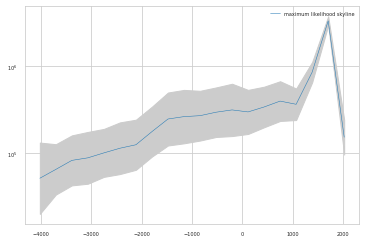

In [44]:
if hasattr(tt, "merger_model"):
    #skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=N_STD)
    #print(skyline)
    #print(conf)
    out_path_skyline_pdf = os.path.join(outdir, SCRIPT_NAME + "_skyline." + FMT )
    out_path_skyline_txt = os.path.join(outdir, SCRIPT_NAME + "_skyline.tsv" )
    treetime.wrappers.print_save_plot_skyline(tt, 
                                              plot=out_path_skyline_pdf, 
                                              save=out_path_skyline_txt,
                                              screen=True,
                                              n_std=2.0, )

---
# Export

## Tree and Dataframe

In [45]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
out_path_pickle_df = os.path.join(outdir,  SCRIPT_NAME + ".df.obj" )

tree_df.to_csv(out_path_df, sep="\t")
with open(out_path_pickle_df,"wb") as outfile:
    dill.dump(tree_df, outfile)
    
# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
out_path_pickle_tree = os.path.join(outdir,  SCRIPT_NAME + ".treetime.obj" )


Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
with open(out_path_pickle_tree,"wb") as outfile:
    dill.dump(tt, outfile)

DEPRECATED: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



## Augur JSON

In [46]:
augur_dict = augur_export(
    tree_path=tree_path, 
    aln_path=aln_path, 
    tree=tt.tree,     
    #tree=tree_div, 
    tree_df=tree_df, 
    color_keyword_exclude=["color", "coord", "reg", "lat", "lon"],
    type_convert = {
        "Branch_Number" : (lambda x : str(x))
    },
)

print(augur_dict["nodes"]["Reference"])

if hasattr(tt, "merger_model"):
    skyline, conf = tt.merger_model.skyline_inferred(gen=50, confidence=2)
    augur_dict['skyline'] = [[float(x) for x in skyline.x], [float(y) for y in conf[0]],
                           [float(y) for y in skyline.y], [float(y) for y in conf[1]]]

out_path_augur_json = os.path.join(outdir, SCRIPT_NAME + "_augur.json" )
utils.write_json(data=augur_dict, file_name=out_path_augur_json, indent=JSON_INDENT)

{'ufboot': 'NA', 'scf': 'NA', 'branch_length': 1.8768e-06, 'strain': 'NA', 'date': 1992.0, 'datebp': -29.0, 'country': 'United States of America', 'province': 'Colorado', 'biovar': 'Orientalis', 'branch_major': '1.ORI', 'branch_minor': '1.ORI1', 'biosample': 'NA', 'biosamplecomment': 'KEEP: Assembly Modern Reference', 'branch_number': '1', 'rate': 3.953384897674909e-08, 'rate_fold_change': 3.926312290519317, 'mutation_length': 1.8768e-06, 'raw_date': '1992-01-01', 'num_date': 1992.0, 'num_date_confidence': [1992.0, 1992.0], 'clock_length': 50.56277076328547}


## Auspice JSON

In [47]:
auspice_dict = auspice_export(
    tree=tt.tree, 
    augur_json_paths=[out_path_augur_json], 
    auspice_config_path=auspice_config_path, 
    auspice_colors_path=auspice_colors_path,
    auspice_latlons_path=auspice_latlon_path, 
    )

# Write outputs - For Local Rendering
out_path_auspice_local_json = os.path.join(outdir, SCRIPT_NAME + "_auspice.json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_local_json)
print("Validation successful for local JSON.")

# Write outputs - For Remote Rendering
out_path_auspice_remote_json = os.path.join(auspice_remote_dir_path, AUSPICE_PREFIX + SCRIPT_NAME.replace("_","-") + ".json" )
utils.write_json(data=auspice_dict, file_name=out_path_auspice_remote_json, indent=JSON_INDENT, include_version=False)
export_v2.validate_data_json(out_path_auspice_remote_json)
print("Validation successful for remote JSON.")

Validating schema of '../../config/auspice_config.json'...
Validation success.


Validating produced JSON
Validating schema of '../../results/clock_model/clock_model_auspice.json'...
Validating that the JSON is internally consistent...
Validation of '../../results/clock_model/clock_model_auspice.json' succeeded.
Validation successful for local JSON.
Validating produced JSON
Validating schema of '../../auspice/plague-phylogeography_clock-model.json'...
Validating that the JSON is internally consistent...
Validation of '../../auspice/plague-phylogeography_clock-model.json' succeeded.
Validation successful for remote JSON.
